
# <span style="color:rgb(213,80,0)">Advanced modeling of diffusion MRI: non Gaussian signal representations</span>

Even if a FW compartment is eliminated from the diffusion signal, DT\-MRI still oversimplifies the diffusion phenomena and is unable to disentangle complex micro\-structural patterns such as crossing fibers. To overcome these limitations, a plethora of alternative signal representations have been developed in the last decade, each with its own pros and cons. These methods may or may not depend on a specific acquistion scheme (e.g. multi\-shell samplings), and are characterized by a variable model complexity (number of degrees of freedom).

<p style="text-align:left">
   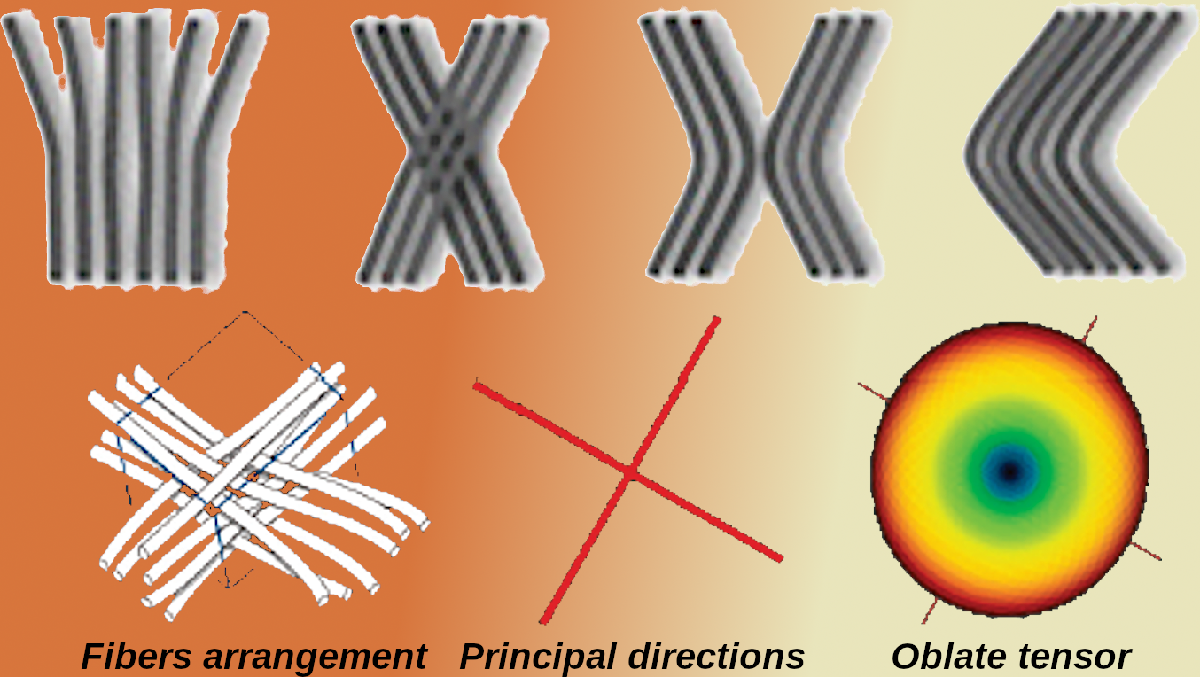
</p>


Remember that the quantitative information provided by DT\-MRI reduces to just 3 independent numbers (the three eigenvalues) that can be combined in different ways (into the MD, FA or whatever other measure). The idea behind general signal representations is that increasing the complexity of the model one can compute a larger number of independent numerical indices, which presumably will better describe the diffusion phenomena attaining higher sensitivity and specificity.


These indices are commonly used as proxies for actual micro\-structural properties. For example, the "return probabilities" (return to origin, RTOP, return to axis, RTAP and return to plane, RTPP) have been used in the literature as proxies for pore volume, cross section area or length.


In this chapter we will examine several such signal representation methods in increasing order of complexity. We will hide all the bothering mathematical or implementation details, and will focus just on their adequacy to each particular kind of data set, briefly showing how to properly compute them with <samp>DMRIMatlab</samp>.


 ***TO DO:*** Clear all variables and figures to start from zero (*Ctrl+ENTER*):


In [ ]:
addpath('..');
setup__DMRIMatlab_toolbox;
clear;
close('all');

## 1\- AMURA

The "Apparent Measures from Reduced Acquisitions" directly computes diffusion indices from the attenuation signal, without the need of an intermediate estimation step:

-  It is intended, and shows its best performance, with single\-shell acquisitions.
-  Unlike DT\-MRI, it can use shells at b\-values over $2,000s/mm^2$ , and it is indeed recommended using mid\-to\-large b\-values.
-  It directly computes diffusion indices from the attenuation signal, and therefore it is unable to disentangle orientation information.
-  The measures obtained are said to be "apparent" since they are linked to the actual b\-value used (different b\-values will lead to very differente diffusion measures).

Let's see how it works from a proper data set (*Ctrl+ENTER*):


In [ ]:
whos -file test_data.mat
load test_data.mat
unique(bi)'
% AMURA is meant to be used with single-shell acquisitions, so we will keep
% just the shell at b=3000
valid = ( (bi>2900) & (bi<3100) );
atti = atti(:,:,:,valid);
gi = gi(valid,:);
bi = bi(valid,1);


Once we have a suitable data set, the diffusion measures are directly calculated. In all cases, the expected input is the atenuation signal <samp>atti</samp>, and the expected output is an apparent diffusion measure at the selected shell computed with AMURA, hence the function is named <samp>atti2amura:</samp>


In [ ]:
% As always, the minimum information required is the attenuation signal and
% the gradients description:
rtop = atti2amura( atti, gi, bi, 'mask', mask, 'type', 'rtop' );
rtap = atti2amura( atti, gi, bi, 'mask', mask, 'type', 'rtap' );
rtpp = atti2amura( atti, gi, bi, 'mask', mask, 'type', 'rtpp' );
% Let's check how these measures look
close(figure(1));
hf1 = figure(1);
set(hf1,'Position',[1,1,800,300]);
plotSlicedVolume_demo1(hf1,rtop,mask,[5,9,13]);
title('AMURA''s RTOP');
close(figure(2));
hf2 = figure(2);
set(hf2,'Position',[1,1,800,300]);
plotSlicedVolume_demo1(hf2,rtap,mask,[5,9,13]);
title('AMURA''s RTAP');
close(figure(3));
hf3 = figure(3);
set(hf3,'Position',[1,1,800,300]);
plotSlicedVolume_demo1(hf3,rtpp,mask,[5,9,13]);
title('AMURA''s RTPP');


***QUIZ:***


 *Can you change the code in the first block so as to use a different shell than the one at* $b=3,000s/mm^2$ *? How do the RTxP maps change when a different b\-value is used (check the ranges of variation in the colorbar)*

## 2\- MiSFIT

The "Micro\-Structure\-adaptive convolution kernels and dual Fourier domains Integral Transforms" is a *spherical convolution* method, meaning that it represents the diffsuion phenomena as the combined effect of a mixture of neural fiber responses for each possible spatial orientation. The individual response of each fiber is called the "convolution kernel", and is nothing but an elemental diffusion tensor with principal eigenvalue $\lambda_{||}$ and two other identical eigenvalues $\lambda_{\perp } ,\lambda_{\perp }$ . The contribution of each spatial orientation to the overall signal is weigthed by the so\-called "fiber Orientation Distribution Function", or simply fODF.

-  This method is meant to be used only with "shelled" acquisitions.
-  Though multi\-shell acquistions are preferable, single\-shell ones can also be used (at the expense of reducing the specificity in the description of the kernel).
-  Unlike AMURA, MiSFIT provides a full representation of the diffusion pocess including orientation (through the fODF). It also allows the synthetization of the attenuation signal from its representation.

MiSFIT proceeds in three stages:

### 2.1 Computation of the convolution kernel

I.e. finding the eigenvalues $\lambda_{||} ,\lambda_{\perp } ,\lambda_{\perp }$ . We begin with the attenuation signal and end\-up with a convolution kernel aimed to describe the micro\-structutal properties of the voxel. Hence, the <samp>atti2micro</samp> function is used (we already did in the previous chapter):


In [ ]:
% Let's load the original data set:
clear;
load test_data.mat
unique(bi)'
% This piece of code will help you to solve the quiz:
bmin = 990;
bmax = 5100;
valid = ( (bi>=bmin) & (bi<=bmax) );
atti = atti(:,:,:,valid);
gi = gi(valid,:);
bi = bi(valid,1);
% Don't pay too much attention to the optional arguments by now:
[lpar,lperp,f] = atti2micro( atti, gi, bi, ...
    'mask', mask, ...
    'usef', true, ...
    'mu', 0.00015, ... % Regularization parameter
    'verbose', true );
% Let's check how things look like:
close(figure(4));
hf4 = figure(4);
set(hf4,'Position',[1,1,800,300]);
plotSlicedVolume_demo1(hf4,lpar,mask,[5,9,13]);
title(' $\lambda_{||}$ ','interpreter','latex');
close(figure(5));
hf5 = figure(5);
set(hf5,'Position',[1,1,800,300]);
plotSlicedVolume_demo1(hf5,lperp,mask,[5,9,13]);
title(' $\lambda_{\perp}$ ','interpreter','latex');
close(figure(6));
hf6 = figure(6);
set(hf6,'Position',[1,1,800,300]);
plotSlicedVolume_demo1(hf6,f,mask,[5,9,13]);
title(' $f$ ','interpreter','latex');


***QUIZ:***

-   *Compare the maps of* $\lambda_{||}$ *and* $\lambda_{\perp }$ *. In which regions are their values roughly the same?*
-  *Change the code so that it only uses 2 shells, and then just 1 shell. How are the results affected?*
-  *Using 2 or 3 shells, switch between '<samp>usef</samp>' <samp>true</samp> or <samp>false</samp>. How are the resutls affected?*
### 2.2 Computation of the fODF

The operation that outputs the fODF from the convolution kernel and the resulting attenuation signal is called "deconvolution". The function used to perform it, according to its expected inputs/outputs, is called <samp>micro2shodf</samp>:


In [ ]:
% The mandatory inputs are:
%    - the attenuation signal atti and its related information gi and bi
%    - the description of the micro-structure kernel lpar, lperp, f
%      computed before with atti2micro
SH = micro2shodf( atti, gi, bi, lpar, lperp, f, ...
    'mask', mask, ...
    'L', 8, ... % The higher this number, the reacher the orientation information
    'optimal', false, ... % A quick, suboptimal estimation is enough for this exercise
    'lambda', 0.0005 ... % Regulrization parameter
    );


The description of the fODF is made through its "Spherical Harmonics" coefficients, a very convenient parametric representation for this kind of functions. Note the amount of coefficients to be used is governed by the EVEN intger L=0,2,4,6,8...


In [ ]:
% Pay attention to the size of SH:
size(SH),
% The first three dimensions are the field of view, the fourth one contains
% the SH coefficients


***QUIZ:***


*Try to change '<samp>L</samp>' to smaller values (2,4,6) and check the size of <samp>SH</samp>. Can you derive a formula relating the number of SH coefficients to the value of L?*

### 2.3 Computation of scalar indices

Once the representation is entirely described through the kernel and the fODF, any scalar index can be computed from them. For example:


In [ ]:
rtop = micro2moments( SH, lpar, lperp, f, 'mask', mask, 'type', 'rtop' );
rtap = micro2moments( SH, lpar, lperp, f, 'mask', mask, 'type', 'rtap' );
rtpp = micro2moments( SH, lpar, lperp, f, 'mask', mask, 'type', 'rtpp' );
close(figure(7));
hf7 = figure(7);
set(hf7,'Position',[1,1,800,300]);
plotSlicedVolume_demo1(hf7,rtop,mask,[5,9,13]);
title('MiSFIT''s RTOP');
close(figure(8));
hf8 = figure(8);
set(hf8,'Position',[1,1,800,300]);
plotSlicedVolume_demo1(hf8,rtap,mask,[5,9,13]);
title('MiSFIT''s RTAP');
close(figure(9));
hf9 = figure(9);
set(hf9,'Position',[1,1,800,300]);
plotSlicedVolume_demo1(hf9,rtpp,mask,[5,9,13]);
title('MiSFIT''s RTPP');

### 2.4 Bonus: resynthesize the attenuation signal from its MiSFIT representation

Since MiSFIT provides a whole representation of the diffusion process, it makes sense that it can be used to go back and retrieve the original attenuation signal. This is achieved with the inverse <samp>micro2atti</samp> function as follows:


In [ ]:
atti2 = micro2atti( SH, lpar, lperp, f, gi, bi, 'mask', mask );
% Let's compare the original signal with its reconstructed version for a
% randomly chosen gradient:
gradient = 13;
close(figure(10));
hf10 = figure(10);
set(hf10,'Position',[1,1,800,300]);
plotSlicedVolume_demo1(hf10,atti(:,:,:,gradient),mask,[5,9,13]);
title('Original');
close(figure(11));
hf11 = figure(11);
set(hf11,'Position',[1,1,800,300]);
plotSlicedVolume_demo1(hf11,atti2(:,:,:,gradient),mask,[5,9,13]);
title('Reconstructed');


As you can see, the reconstructed image is a "clean" version of the original one.

## 3\- MAP\-MRI/MAPL

The "Mean Apparent Propagator MRI" (or its Laplacian\-regularized version, MAPL) represents the diffusion process by decomposing the attenuation signal as the sum of a series of basis fucntions with increasing complexity up to an (EVEN) order $N_{max}$ . Remarkably, the 0\-th order cumulant reduces to the DTI representation, upon which progressive refinements are built for orders other than 0.

-  MAPL can be used, in principle, with any kind of diffusion acquisitions, including multi\-shell, cartesian or hybrid samplings. Nonetheless, it was originally intended for multi\-shell acquisitions.
-  It deploys an entire representation of the diffusion process, including scalar indices and orientation information. Accordingly, it can also be used to re\-synthesize the attenuation signal.
-  It has been longly considered as the *de facto*  standard in signal representations for diffusion MRI.
-  You might have already used the implementation in Python's <samp>dipy</samp> package and get frustrated with the painfully long processing times. The implementation in <samp>DMRIMatlab</samp> is pretty faster (one order of magnitude).
### 3.1. Computation of the signal representation

As opposed to MiSFIT, the computation of the signal representation is now a one\-step procedure: it takes the attenuation signal as input and outputs the MAPL coefficients, hence the function is named <samp>atti2mapl</samp>:


In [ ]:
% Let's load the original data set:
clear;
load test_data.mat
unique(bi)'
% Let's work with just 3 slices to speed up computations:
atti = atti(:,:,[5,9,13],:);
mask = mask(:,:,[5,9,13]);
% Compute the representation. Note the optional arguments are not
% representative of a real world situation. Instead, we have chosen a
% "modest" configuration for this proof of concept, so that you can run the
% code quickly. The parameters affecting the most to the computation times
% are:
%   - Nmax, which is the maximum order for the basis functions and
%     directly determines the number of MAPL coefficients to compute
%   - constRad, which governs the number of constraints added to the
%     optimization problem that finds these coefficients
tic;
[mapl,dti] = atti2mapl( atti, gi, bi, ...
    'mask', mask, ...
    'Nmax', 4, ...
    'lambda', 0.2, ... % Regularization parameter
    'const', true, ...
    'constRad', 7 ...
    );
fprintf(1,'It tool %1.3f seconds to compute MAPL coefficients\n',toc);
% Check the size of the output:
size(mapl),


Note that the function returns the MAPL coefficients and a DTI volume. Remember that MAPL builds succesive refinements of the signal upon the DTI representation, hence the latter is essential to interpret the MAPL coefficients themselves.


***QUIZ:***


*Change Nmax to 2 and check the results. If your computer is powerful enough, try also to change it to 6.*

### 3.2. Computation of scalar indices

From the MAPL coefficients, it is immediate to compute scalar indices. Obviously the name of the function to use is <samp>mapl2index</samp>. This function will take as inputs not only the MAPL coefficients, but also the underlying DTI representation necessary to interpret them:

<pre>
help mapl2index
</pre>

In [ ]:
rtop = mapl2index( mapl, dti, 'mask', mask, 'type', 'o' );
rtap = mapl2index( mapl, dti, 'mask', mask, 'type', 'a' );
rtpp = mapl2index( mapl, dti, 'mask', mask, 'type', 'p' );
close(figure(12));
hf12 = figure(12);
set(hf12,'Position',[1,1,800,300]);
plotSlicedVolume_demo1(hf12,rtop,mask,[1,2,3]);
title('MAPL''s RTOP');
close(figure(13));
hf13 = figure(13);
set(hf13,'Position',[1,1,800,300]);
plotSlicedVolume_demo1(hf13,rtap,mask,[1,2,3]);
title('MAPL''s RTAP');
close(figure(14));
hf14 = figure(14);
set(hf14,'Position',[1,1,800,300]);
plotSlicedVolume_demo1(hf14,rtpp,mask,[1,2,3]);
title('MAPL''s RTPP');


 ***QUIZ:***


 *Since MAPL provides a full signal representation, it should be able to reconstruct the original attenuation signal from the MAPL coefficients (and the DTI volume). Can you do so?* ***HINT*** *: Check the function* *<samp>mapl2atti</samp>.*

<pre>
help mapl2atti
</pre>

## 4\- HYDI\-DSI

The "Hybrid Diffusion Imaging\-Diffusion Spectrum Imaging" is an entirely different conception. It exploits the relationship between the attenuation signal and the "Ensemble Average Propagator" (i.e. the map of possible displacements water molecules can undergo within a voxel) as a pair of Fourier direct\-inverse transforms to numerically obtain a regular cartesian sampling of this EAP:

-  The number of degrees of freedom of this representation is potentially much larger than those in the previous methods.
-  As in MAPL, our implementation builds the representation of the signal upon the basic DTI. This means that, like in MAPL, the DTI volume is required to interpret the numerical values sampled from the EAP.
-  This method can work with any kind of diffusion sampling: shelled (even single\-shells work pretty decently), cartesian, hybrid, random\-like...
-  This method is computationally heavy!!!
### 4.1. Computation of the signal representation

As in MAPL, the computation of the signal representation is done in single\-step, and the basic DTI is also returned. Yet, some additional parameters related to the bandwidth of the signal are also returned and needed for the interpretation:


In [ ]:
% Let's load the original data set:
clear;
load test_data.mat
unique(bi)'
% Let's work with just 3 slices to speed up computations:
atti = atti(:,:,[5,9,13],:);
mask = mask(:,:,[5,9,13]);
% Compute the representation. Note the optional arguments are not
% representative of a real world situation. Instead, we have chosen a
% "modest" configuration for this proof of concept, so that you can run the
% code quickly. The parameters affecting the most to the computation times
% are:
%   - lattice, which governs the actual number of samples to be computed
%     for the EAP. Note lattice is also returned as an output because if
%     you pass an empy lattice [] as input the algorithm will decide for
%     you.
tic;
[eap,dti,lattice,Qx,Qy,Qz] = atti2hydidsi( atti, gi, bi, ...
    'mask', mask, ...
    'lambda', 0.2, ... % Regularization parameter
    'lattice', [2;2;3] ... % Use a small lattice to keep a reasonable load
    );
fprintf(1,'It tool %1.3f seconds to compute the EAP sampling\n',toc);
% Check the size of the output:
size(eap),


***QUIZ:***


 *A lattice radius \[m;n;p\] means that the EAP is sampled in a* $(2m+1)\times (2n+1)\times (2p+1)$ *regular cartesian grid. You can check that a lattice size \[3;3;3\] does not produce a 7\*7\*7 = 343 size of the fourth dimension of the output, but instead (7\*7\*7+1)/2 = 172. Can you guess why? HINT: Check the help on the* *<samp>lattice</samp>* *parameter in* *<samp>atti2hydidsi</samp>.*

<pre>
help atti2hydidsi
</pre>

### 4.2. Computation of scalar indices

From the EAP sampling, it is immediate to compute scalar indices. Obviously the name of the function to use is <samp>hydidsi2index</samp>. This function will take as inputs not only the EAP sampling coefficients, but also the bandwidth information necessary to interpret them (<samp>Qx</samp>, <samp>Qy</samp>, <samp>Qz</samp>) and the lattice size:


In [ ]:
rtop = hydidsi2index( eap, lattice, Qx, Qy, Qz, 'mask', mask, 'kind', 'rtop' );
rtap = hydidsi2index( eap, lattice, Qx, Qy, Qz, 'mask', mask, 'kind', 'rtap' );
rtpp = hydidsi2index( eap, lattice, Qx, Qy, Qz, 'mask', mask, 'kind', 'rtpp' );
close(figure(15));
hf15 = figure(15);
set(hf15,'Position',[1,1,800,300]);
plotSlicedVolume_demo1(hf15,rtop,mask,[1,2,3]);
title('HYDI-DSI''s RTOP');
close(figure(16));
hf16 = figure(16);
set(hf16,'Position',[1,1,800,300]);
plotSlicedVolume_demo1(hf16,rtap,mask,[1,2,3]);
title('HYDI-DSI''s RTAP');
close(figure(17));
hf17 = figure(17);
set(hf17,'Position',[1,1,800,300]);
plotSlicedVolume_demo1(hf17,rtpp,mask,[1,2,3]);
title('HYDI-DSI''s RTPP');


 ***QUIZ:***


 *Since HYDI\-DSI provides a full signal representation, it should be able to reconstruct the original attenuation signal from the EAP coefficients (and the lattice size and bandwidth description). Can you do so?* ***HINT*** *: Check the function* *<samp>hydidsi2atti</samp>.*

<pre>
help hydidsi2atti
</pre>

[Go back to index page](./tour_00index.ipynb)


[Previous](./tour_04fwvf.ipynb)


[Next](./tour_06representations.ipynb)

